# LSTM-Based Model for ECG Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
output_dir = "/content/drive/Shareddrives/Labs CompBioMed/results"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Change these paths accordingly
import zipfile

zip_path = "/content/drive/Shareddrives/Labs CompBioMed/data.zip"
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")

Extraction completed!


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, hamming_loss
from ast import literal_eval
import glob
import wfdb

## 1. Label Preparation for Model Training

In [ ]:
# Preprocessing
base_dir = "/content/data/data"
csv_path = os.path.join(base_dir, "ptbxl_database.csv")
record_dir = os.path.join(base_dir, "records100")
scp_path = os.path.join(base_dir, "scp_statements.csv")

variables = pd.read_csv(csv_path, index_col=0)
files = glob.glob(os.path.join(record_dir, "**", "*.dat"), recursive=True)
files = [f for f in files if f.endswith(".dat")]
ecg_ids = [int(os.path.basename(f).split("_")[0]) for f in files]
variables = variables.loc[variables.index.isin(ecg_ids)]

ordered_indices = [i for i in ecg_ids if i in variables.index]
variables = variables.loc[ordered_indices]
variables["scp_codes"] = variables["scp_codes"].apply(literal_eval)

scp_df = pd.read_csv(scp_path, index_col=0)
scp_map = scp_df[scp_df["diagnostic_class"].notnull()]["diagnostic_class"].to_dict()

def map_to_superclass(scp_codes):
    return list({scp_map[code] for code in scp_codes if code in scp_map})

variables["diagnostic_superclass"] = variables["scp_codes"].apply(map_to_superclass)
target_labels = {"NORM", "MI", "STTC"}
variables = variables[variables["diagnostic_superclass"].apply(lambda x: bool(set(x) & target_labels))]

# Train/test split
test_fold = 10
train_df = variables[variables["strat_fold"] != test_fold]
test_df = variables[variables["strat_fold"] == test_fold]

## 2. Signal Loading and Preprocessing

In [ ]:
# Load raw signals
def load_raw_data(df, base_path):
    signals = []
    for path in df["filename_lr"]:
        signal, _ = wfdb.rdsamp(os.path.join(base_path, path))
        signals.append(signal)
    return np.array(signals)

X_train = load_raw_data(train_df, base_dir)
X_test = load_raw_data(test_df, base_dir)

def normalize(ecg):
    return (ecg - np.mean(ecg, axis=0)) / (np.std(ecg, axis=0) + 1e-8)

X_train = np.array([normalize(sig) for sig in X_train])
X_test = np.array([normalize(sig) for sig in X_test])

mlb = MultiLabelBinarizer(classes=["NORM", "MI", "STTC"])
mlb.fit(variables["diagnostic_superclass"])

y_train = mlb.transform(train_df["diagnostic_superclass"])
y_test = mlb.transform(test_df["diagnostic_superclass"])

# Count label occurrences in the multi-label training set
label_counts = np.sum(y_train, axis=0)
label_names = mlb.classes_

print("\nTraining label distribution:")
for label, count in zip(label_names, label_counts):
    print(f"{label}: {int(count)}")


Training label distribution:
NORM: 8551
MI: 4919
STTC: 4714


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['CD', 'HYP'] will be ignored
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. LSTM Architecture

In [ ]:
# Define LSTM1D Model
class LSTM1D(nn.Module):
    def __init__(self, input_channels=12, hidden_dim=128, num_classes=3, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_channels,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False,
                            dropout=dropout)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (N, C, L) -> (N, L, C)
        lstm_out, _ = self.lstm(x)  # (N, L, hidden)
        lstm_out = lstm_out.permute(0, 2, 1)  # (N, hidden, L)
        return self.classifier(lstm_out)

## 4. Model Training and Evaluation

In [ ]:
# Training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

model = LSTM1D().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
best_loss = float('inf')
patience = 5
patience_counter = 0
best_epoch = 0

train_losses = []
test_losses = []
train_accuracies= []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == y_batch).all(dim=1).sum().item()
        total += y_batch.size(0)
    train_losses.append(train_loss / total)
    train_accuracies.append(correct / total)

    # Evaluation
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == y_batch).all(dim=1).sum().item()
            total += y_batch.size(0)
    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
        print(f"Best model saved at epoch {epoch+1}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (best at epoch {best_epoch})")
            break

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Test Loss={test_losses[-1]:.4f}")

Best model saved at epoch 1
Epoch 1: Train Loss=0.4764, Test Loss=0.3989
Best model saved at epoch 2
Epoch 2: Train Loss=0.3775, Test Loss=0.3568
Epoch 3: Train Loss=0.3548, Test Loss=0.4555
Best model saved at epoch 4
Epoch 4: Train Loss=0.3492, Test Loss=0.3438
Best model saved at epoch 5
Epoch 5: Train Loss=0.3232, Test Loss=0.3419
Best model saved at epoch 6
Epoch 6: Train Loss=0.3932, Test Loss=0.3364
Best model saved at epoch 7
Epoch 7: Train Loss=0.3128, Test Loss=0.3179
Best model saved at epoch 8
Epoch 8: Train Loss=0.2983, Test Loss=0.3172
Best model saved at epoch 9
Epoch 9: Train Loss=0.2919, Test Loss=0.3020
Best model saved at epoch 10
Epoch 10: Train Loss=0.2829, Test Loss=0.2956
Best model saved at epoch 11
Epoch 11: Train Loss=0.2750, Test Loss=0.2951
Epoch 12: Train Loss=0.2669, Test Loss=0.2962
Best model saved at epoch 13
Epoch 13: Train Loss=0.2659, Test Loss=0.2869
Epoch 14: Train Loss=0.2620, Test Loss=0.3000
Epoch 15: Train Loss=0.2566, Test Loss=0.2912
Epoch 16

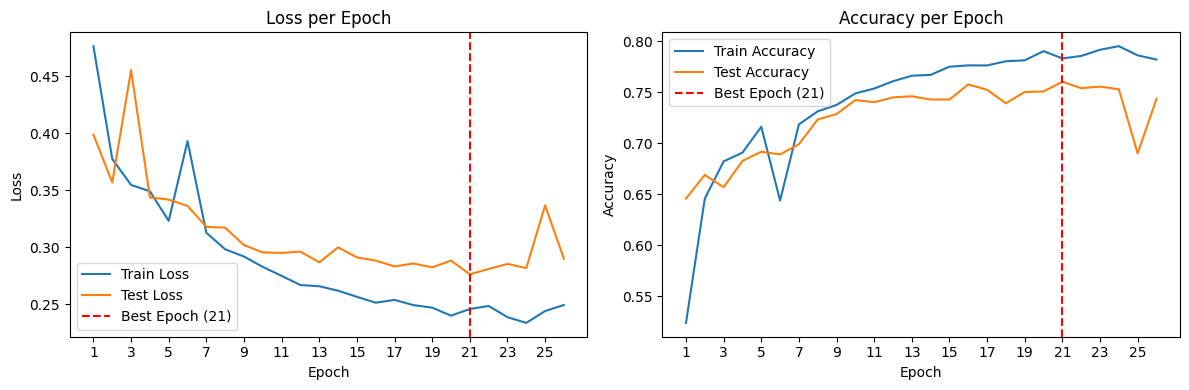

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

epochs_range = range(1, len(train_losses) + 1)  # Start at 1 instead of 0

# Loss per Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses) + 1, 2))  # Integer ticks starting at 1
plt.legend()

# Accuracy per Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies) + 1, 2))
plt.legend()
plt.tight_layout()
lstm_plot_path = os.path.join(output_dir, "lstm_loss_acc_curves.png")
plt.savefig(lstm_plot_path)
plt.show()

In [ ]:
# Load best model for evaluation
model.load_state_dict(torch.load("best_lstm_model.pt"))
model.eval()

# Subset accuracy and loss
correct, total, test_loss = 0, 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == y_batch).all(dim=1).sum().item()
        total += y_batch.size(0)

final_loss = test_loss / total
final_acc = correct / total
print(f"Best model test loss: {final_loss:.4f}")
print(f"Best model test subset accuracy: {final_acc:.4f}")

Best model test loss: 0.2764
Best model test subset accuracy: 0.7604


In [ ]:
from sklearn.metrics import classification_report, hamming_loss

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y_batch.numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Metrics
print(classification_report(all_labels, all_preds, target_names=mlb.classes_, digits=4))
print(f"Hamming Loss: {hamming_loss(all_labels, all_preds):.4f}")

              precision    recall  f1-score   support

        NORM     0.8718    0.9107    0.8908       963
          MI     0.8028    0.7255    0.7622       550
        STTC     0.8069    0.7620    0.7838       521

   micro avg     0.8386    0.8225    0.8305      2034
   macro avg     0.8272    0.7994    0.8123      2034
weighted avg     0.8365    0.8225    0.8286      2034
 samples avg     0.8215    0.8295    0.8183      2034

Hamming Loss: 0.1204


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
